## Time Series

<ul>
    <li>A time series is a sequence set of data points, measured typically over successive times</li>
    <li>It is mathematically defined as a set of vecotrs x(t), t=0,1,2,... where t represents the time elapsed</li>
    <li>The variable x(t) is treated as a random variable</li>
    <li>The measurement taken during an event in a time series are arranged in a proper chronological order</li>
    <li>A time series containing records of a single variable is termed as univariante and more than one variable a multivariant</li>
</ul>

## Business use cases of time series forcasting

<ul>
    <li>Sales forcast - retail products sales forcast</li>
    <li>Demand forcasting - uses in pricing, inventory and workforce management</li>
    <li>Traffic forecast - transport and route optimization, road facility design</li>
    <li>Revenue forcast - budgeting, target setting</li>
</ul>

## Importing Libraries for time series forcasting

In [4]:
import warnings 
import itertools
import numpy as numpy
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA 
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from fbprophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error


## Importing Data

<ul>
    <li>Dataset: International airline passenger</li>
    <li>Unit: Thousands</li>
</ul>

In [46]:
df = pd.read_csv('data/international-airline-passengers.csv')

In [47]:
df.shape

(144, 2)

In [48]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [49]:
df.rename(columns = {'Month': 'year', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60': 'passengers'}, inplace = True)

In [50]:
df.head(3)

,year,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [51]:
df.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [52]:
df.describe(include='O')

,year
count,144
unique,144
top,1950-06
freq,1


## Data Preprocessing and Visualization

#### Converting to datetime format

In [53]:
df['year'] = pd.to_datetime(df['year'], format = '%Y-%m')

#### Setting index as the datetime column for easier manipulations:

In [54]:
y = df.set_index('year')

In [55]:
y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='year', length=144, freq=None)

In [56]:
y.isnull().sum()

passengers    0
dtype: int64

<AxesSubplot:xlabel='year'>

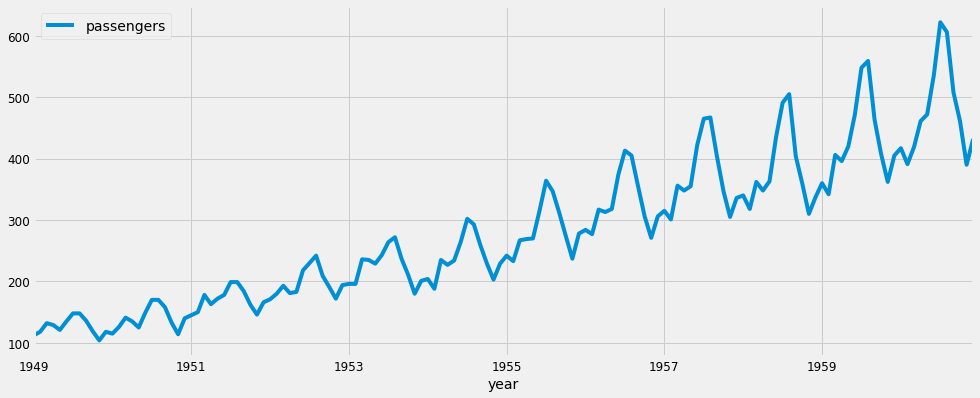

In [57]:
y.plot(figsize=(15, 6))

#### Reviewing plots of the density of observations can provide future insight intothe structure of the data:

<ul>
    <li>The distribution is not perfectly Gaussian (normal distribution)</li>
    <li>The distribution is left shifted</li>
    <li>Transformation might be usefull prior to modeling</li>
</ul>

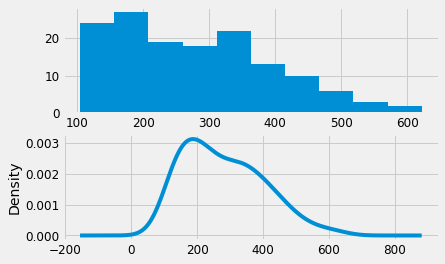

In [58]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.passengers.hist()
pyplot.subplot(212)
y.passengers.plot(kind='kde')
pyplot.show()

#### Box and Whisker Plots:

<ul>
<li>Median value across year confirms an upwards trend</li>
<li>Stedy increases in the spread or middle 50% of the data (boxes) over time</li>
<li>A model considering seasonality might work well</li>
</ul>

<AxesSubplot:xlabel='year', ylabel='passengers'>

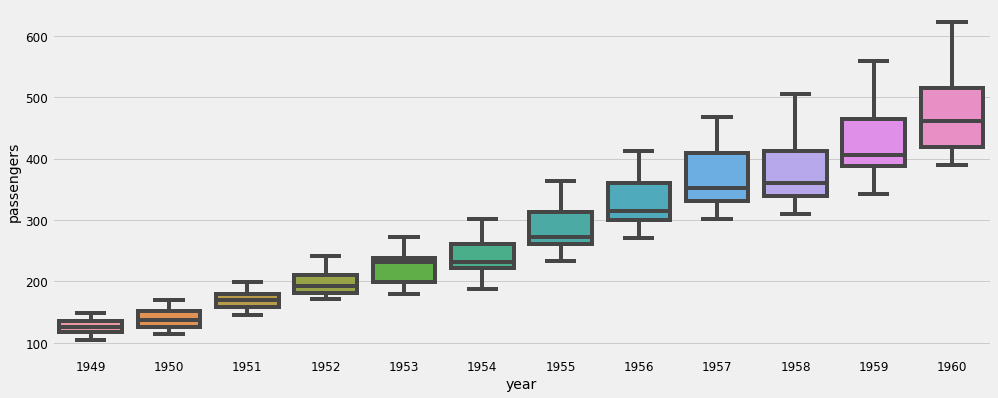

In [59]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.passengers.index.year, y.passengers, ax=ax)

### Decomposing using stats model:

<ul>
<li>We can use stats model to perform a decomposition of this time series</li>
<li>The decomposing of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns</li>
<li>With stats models we will be able to see the trends seasonal, and residual components of out data. </li>
</ul>

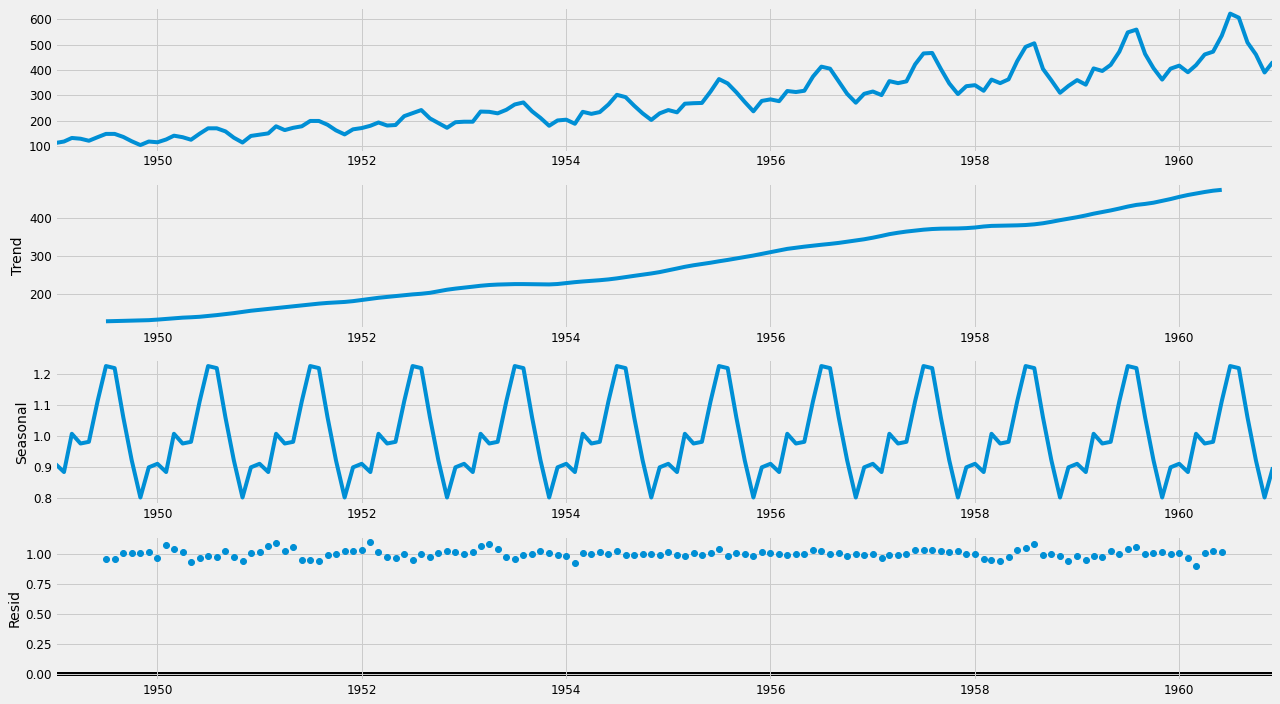

In [74]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

## Stationarity
<ul>
    <li>A Time Series is said to be stationary if its stastical properties sush as mean, variance remain constant over time.</li>
    <li>Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but one way for stationary.</li>
    <li>Intutively we can say that if a Time Series has a particular behavour over time there is a very high probablity that it will follow the same in the future
    <li>Also the theories related ti stationary series are more mature and easier to implement as compared to non-stationary series.</li>
<ul>    

<AxesSubplot:xlabel='year'>

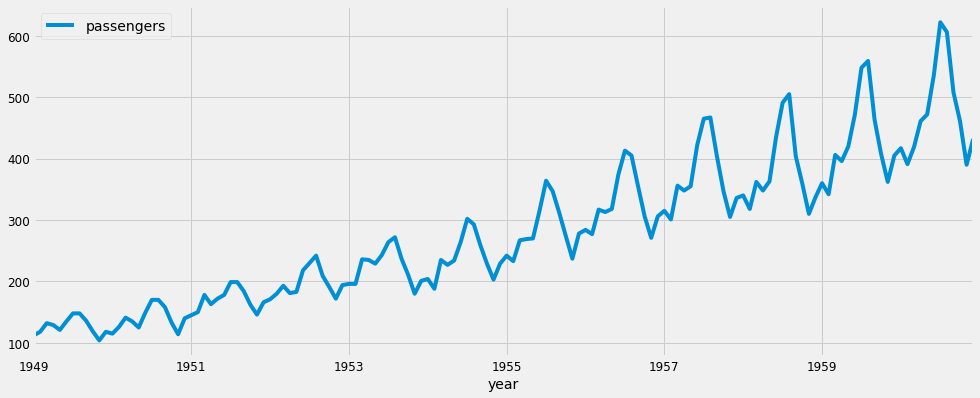

In [75]:
y.plot(figsize=(15, 6))

### We can check stationary using the followin:
<ul>
    <li><b>ACF and PACF plots</b>:If the TS is stationary, the ACF/PACF plots will show a <b>quick drop-off in correlation</b> after a small amount of lag between points</li>
    <li><b>Plotting Rolling Statistics:</b>We can plot the moving average or moving variance ans see if it varies with time. Moving average/variance is for any instant 't', the average/variance of the last year. i.e last 12 months</li>
    <li><b>Augmented Dickey-Fuller Test</b>: This is one of the stastical tests for checking stationary. here the null hypothesis is that the TS is non-stationary. The test results comprise of a test Statistics ans some Critical Values for difference confidence levels. If the 'Test Statistic' is less than the 'Critical Value', we can reject the null hypothesis and say that the series is stationary. Refer the article for details</li>
</ul>

### ACF and PACF plots

<ul>
    <li>let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PCAF) plots</li>
    <li>If the time series is stationary, the ACF/PACF plots will show a <b>quick drop=off in correlation</b> after a small amount of lag between points</li>
    <li>This data is non-stationary as high number of previous observation are correlated with future values.</li>
    <li>Confidence intervals are drown as a cone</li>
    <li>By default, this is et to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statisical fluke.</li>
    <li>The partial autocorrelation atlag k is the correation that results after removing the effect of any correlation due to the terms at shorter lags</li>
</ul>